### HOMEWORK

- Reimplement the NeuralNetwork class by using the Perceptron class inside it (e.g. a layer is an array of perceptrons)
- Inside the class extract weights and other info from the Perceptrons to allow vector-matrix efficient multiplications
- (BONUS) make everything not using matrix multiplications, but rather for loops iterating over list of Perceptrons

### Rete neurale artificiale che utilizza il perceptron come unità di calcolo 
(NO BONUS)

In [16]:
import numpy as np
import matplotlib.pyplot as plt

class Perceptron:
    def __init__(self, input_size, activation_function, activation_derivative):
        # Inizializza i pesi e il bias
        self.weights = np.random.randn(input_size) * 0.01  # Pesos con dimensione input_size
        self.bias = np.random.randn() * 0.01  # Bias
        self.activation_function = activation_function
        self.activation_derivative = activation_derivative
        self.last_input = None
        self.last_output = None

    def activate(self, x):
        self.last_input = x
        z = np.dot(x, self.weights) + self.bias  # Somma pesata
        self.last_output = self.activation_function(z)
        return self.last_output

    def get_weights(self):
        return self.weights
    
    def get_bias(self):
        return self.bias
    
    def set_weights(self, weights):
        self.weights = weights
        
    def set_bias(self, bias):
        self.bias = bias


In [17]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, activation_function, activation_derivative):
        # Crea il layer nascosto con perceptron con funzione di attivazione ReLU
        self.hidden_layer = [Perceptron(input_size, activation_function, activation_derivative) for _ in range(hidden_size)]
        
        # Crea il layer di output con perceptron con funzione di attivazione sigmoid
        self.output_layer = [Perceptron(hidden_size, sigmoid, sigmoid_derivative) for _ in range(output_size)]

        self.extract_parameters()

    def extract_parameters(self):
        """Estrai pesi e bias per operazioni matriciali"""
        # Estrai i pesi e i bias del layer nascosto
        self.W1 = np.array([p.get_weights() for p in self.hidden_layer]).T
        self.b1 = np.array([p.get_bias() for p in self.hidden_layer]).reshape(1, -1)
        
        # Estrai i pesi e i bias del layer di output
        self.W2 = np.array([p.get_weights() for p in self.output_layer]).T
        self.b2 = np.array([p.get_bias() for p in self.output_layer]).reshape(1, -1)
    
    def update_perceptrons(self):
        """Aggiorna i perceptron con i pesi e i bias correnti"""
        # Aggiorna i perceptron del layer nascosto
        for i, perceptron in enumerate(self.hidden_layer):
            perceptron.set_weights(self.W1[:, i])
            perceptron.set_bias(self.b1[0, i])
        
        # Aggiorna i perceptron del layer di output
        for i, perceptron in enumerate(self.output_layer):
            perceptron.set_weights(self.W2[:, i])
            perceptron.set_bias(self.b2[0, i])
    
    def forward(self, X):
        """Propagazione in avanti"""
        # Primo layer (input -> hidden)
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = relu(self.z1)
        
        # Secondo layer (hidden -> output)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = sigmoid(self.z2)
        
        return self.a2
    
    def compute_loss(self, y_true, y_pred):
        """Perdita binaria (cross-entropy)"""
        m = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred + 1e-15) + (1 - y_true) * np.log(1 - y_pred + 1e-15)) / m
        return loss
    
    def backward(self, X, y):
        """Propagazione inversa per calcolare i gradienti"""
        m = X.shape[0]
        
        # Gradiente per il layer di output
        dz2 = self.a2 - y.reshape(-1, 1)
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        
        # Gradiente per il layer nascosto
        dz1 = np.dot(dz2, self.W2.T) * relu_derivative(self.z1)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        
        return dW1, db1, dW2, db2
    
    def update_parameters(self, dW1, db1, dW2, db2, learning_rate):
        """Aggiorna i pesi e i bias tramite discesa del gradiente"""
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        
        # Aggiorna i perceptron con i nuovi pesi e bias
        self.update_perceptrons()
    
    def train(self, X, y, learning_rate=0.1, epochs=1000, print_every=100):
        """Allenamento del modello"""
        losses = []
        
        for epoch in range(epochs):
            # Passaggio in avanti
            y_pred = self.forward(X)
            
            # Calcola la perdita
            loss = self.compute_loss(y.reshape(-1, 1), y_pred)
            losses.append(loss)
            
            # Passaggio inverso
            dW1, db1, dW2, db2 = self.backward(X, y)
            
            # Aggiorna i parametri
            self.update_parameters(dW1, db1, dW2, db2, learning_rate)
            
            if epoch % print_every == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
        
        return losses
    
    def predict(self, X, threshold=0.5):
        """Previsioni binarie"""
        y_pred = self.forward(X)
        return (y_pred >= threshold).astype(int)

# Funzioni di attivazione e derivate
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Evita overflow

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)


In [18]:
# Esempio di utilizzo con il dataset make_moons
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Caricamento del dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Suddividi in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
# Normalizza i dati
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# Inizializza il modello
input_size = X_train.shape[1]  # 2 per il dataset make_moons (due feature)
hidden_size = 100  # Numero di neuroni nel layer nascosto
output_size = 1  # Problema di classificazione binaria
learning_rate = 0.3
epochs = 2000

# Crea il modello
model = NeuralNetwork(input_size, hidden_size, output_size, relu, relu_derivative)

# Allena il modello
losses = model.train(X_train, y_train, learning_rate=learning_rate, epochs=epochs, print_every=100)

Epoch 0, Loss: 0.6933
Epoch 100, Loss: 0.3056
Epoch 200, Loss: 0.2999
Epoch 300, Loss: 0.2974
Epoch 400, Loss: 0.2961
Epoch 500, Loss: 0.2944
Epoch 600, Loss: 0.2909
Epoch 700, Loss: 0.2833
Epoch 800, Loss: 0.2681
Epoch 900, Loss: 0.2423
Epoch 1000, Loss: 0.2081
Epoch 1100, Loss: 0.1746
Epoch 1200, Loss: 0.1482
Epoch 1300, Loss: 0.1291
Epoch 1400, Loss: 0.1141
Epoch 1500, Loss: 0.1039
Epoch 1600, Loss: 0.0966
Epoch 1700, Loss: 0.0917
Epoch 1800, Loss: 0.0869
Epoch 1900, Loss: 0.0828


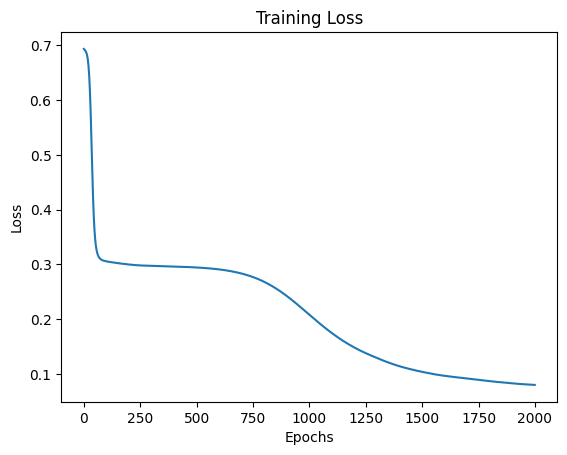

In [21]:
# Visualizza il grafico delle perdite durante l'allenamento
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [22]:
from sklearn.metrics import accuracy_score

# Previsioni sul set di test
y_pred = model.predict(X_test)

# Calcola l'accuratezza
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.9700


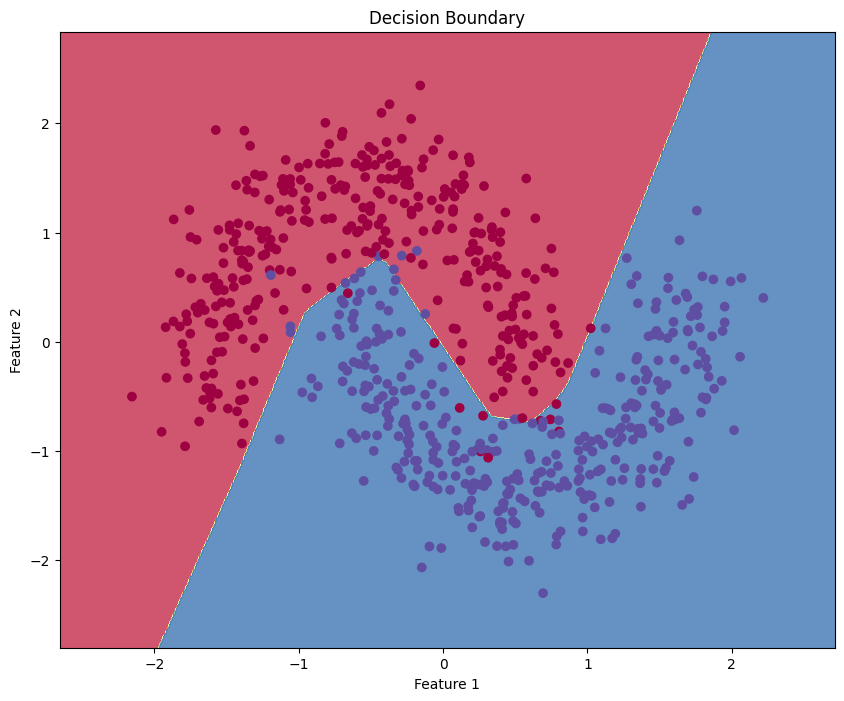

In [23]:
def plot_decision_boundary(X, y, model):
    """Plot the decision boundary of the trained model"""
    # Set min and max values with some margin
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    # Generate a grid of points
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Make predictions on the grid points
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.show()

# Visualizza la decision boundary
plot_decision_boundary(X_train, y_train, model)

### La Classe Perceptron
La classe PerceptroN rappresenta un singolo neurone in una rete neurale. Ogni perceptron ha:
- **Pesi (weights)**: Rappresentano l'importanza di ciascun input per il perceptron. I pesi sono inizializzati in modo casuale e vengono aggiornati durante l'allenamento.
- **Bias (bias)**: Un valore aggiunto alla somma pesata degli input per permettere alla rete di apprendere anche una "soglia" per l'attivazione. Come i pesi, il bias è aggiornato durante l'allenamento.
- **Funzione di attivazione (activation_function)**: Una funzione non lineare che decide se il neurone deve "accendersi" o meno in base al valore dell'input. Nel nostro caso, il perceptron del layer nascosto usa la funzione ReLU, mentre il perceptron dell'output utilizza la funzione Sigmoid.
- **Derivata della funzione di attivazione (activation_derivative)**: Una funzione che calcola il gradiente della funzione di attivazione. Questo è necessario durante la propagazione inversa (backpropagation) per aggiornare i pesi in modo efficiente.

Ogni perceptron ha due metodi principali:
- **activate(x)**: Calcola l'output del perceptron dato un input `x`. Questo metodo esegue il calcolo della somma pesata (`z = x * weights + bias`) e quindi applica la funzione di attivazione.
- **get_weights()` e `get_bias()**: Restituiscono i pesi e il bias del perceptron.
- **set_weights() e set_bias()**: Impostano i pesi e il bias del perceptron. Questi vengono utilizzati per aggiornare i parametri durante l'allenamento.

### La Classe NeuralNetwork
La classe NeuralNetworK definisce una rete neurale composta da:
1. **Layer nascosti**: Ogni layer nascosto è composto da più perceptron, ciascuno dei quali calcola un'uscita basata sugli input ricevuti e sui suoi pesi.
2. **Layer di output**: Analogamente ai layer nascosti, il layer di output è composto da perceptron che calcolano l'output finale della rete.

Ogni neurone della rete (sia nei layer nascosti che nell'output) è rappresentato dalla classe Perceptron. I parametri (pesi e bias) di questi perceptron sono memorizzati in matrici (e vettori) per efficienti operazioni matriciali.

I principali metodi della classe `NeuralNetwork` sono:
- **forward(X)**: La propagazione in avanti (forward pass). Calcola l'output della rete partendo dagli input, passando attraverso il layer nascosto e infine arrivando al layer di output.
- **compute_loss(y_true, y_pred)**: Calcola la funzione di perdita, che misura quanto le predizioni del modello differiscono dai valori veri.
- **backward(X, y)**: Propagazione inversa (backpropagation) per calcolare i gradienti dei pesi e dei bias, necessari per aggiornare i parametri del modello.
- **update_parameters(dW1, db1, dW2, db2, learning_rate)**: Aggiorna i pesi e i bias della rete utilizzando la discesa del gradiente, sfruttando i gradienti calcolati nella propagazione inversa.
- **train(X, y, learning_rate, epochs, print_every)**: Allena il modello sui dati di training. Per ogni epoca, esegue un passaggio in avanti, calcola la perdita, esegue un passaggio inverso e aggiorna i parametri.
- **predict(X, threshold)**: Prevede l'output della rete per un dato input, applicando una soglia (di solito 0.5) per la classificazione binaria.

### La Propagazione Inversa (Backpropagation)
Durante l'allenamento, il modello utilizza la **propagazione inversa** per aggiornare i pesi e i bias. Dopo aver calcolato l'errore (perdita) durante il passaggio in avanti, la rete calcola i gradienti (derivate) della perdita rispetto ai pesi e ai bias. Questi gradienti vengono usati per aggiornare i pesi e i bias in modo tale da ridurre l'errore nei passi successivi.

### Funzioni di Attivazione
- **ReLU**: La funzione di attivazione del layer nascosto è la funzione ReLU (Rectified Linear Unit), che restituisce 0 per input negativi e il valore stesso per input positivi.
  
- **Sigmoid**: La funzione di attivazione del layer di output è la funzione Sigmoid che restituisce valori compresi tra 0 e 1

### Training e Predizione
1. **Allenamento**: Durante l'allenamento, la rete neurale cerca di ridurre la **perdita** ottimizzando i pesi e i bias.
2. **Predizione**: Una volta allenato, il modello può fare delle predizioni per nuovi dati. 

### Risultati del Modello
Alla fine dell'allenamento, la rete neurale ha appreso a classificare correttamente i dati di input in base ai target. 
